In [11]:
# Import specific functions
import sys
import numpy as np
from numpy.linalg import eig, inv, pinv, eigvals
from scipy.spatial.distance import squareform, pdist
from scipy.sparse import csr_matrix, random as sparse_random, find, issparse
from scipy.stats import multivariate_normal as mvnpdf
import time
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import inv
import numpy as np
import scipy.sparse as sp
from scipy.spatial.distance import squareform
from scipy.sparse import triu, coo_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, normalized_mutual_info_score
sys.path.append('/Users/paul_reitz/Documents/repos/PyAWGLMM/Smooth_AWGLMM')
from scripts.utils import (
    visualize_glmm,
    graph_learning_perf_eval,
    identify_and_compare,
    generate_connected_graph,
    normest,
    lin_map,
    squareform_sp,
    sum_squareform,
    prox_sum_log,
    gsp_distanz,
)


In [12]:
def squareform_sp(w):
    """
    Sparse counterpart of numpy's squareform
    
    Parameters:
    w : sparse or dense vector with n(n-1)/2 elements OR matrix with size [n, n] and zero diagonal
    
    Returns:
    W : matrix form of input vector w OR vector form of input matrix W
    """
    if sp.issparse(w):
        is_sparse = True
    else:
        is_sparse = False
        w = np.asarray(w)
    
    # Determine if input is a vector
    if w.ndim == 1 or w.shape[0] == 1 or w.shape[1] == 1:
        # VECTOR -> MATRIX
        l = w.size
        n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))
        if l != n * (n - 1) // 2:
            raise ValueError("Bad vector size!")
        
        if is_sparse:
            ind_vec = w.nonzero()[0]
            s = w.data
        else:
            ind_vec = np.nonzero(w)[0]
            s = w[ind_vec]
        
        num_nz = len(ind_vec)
        ind_i = np.zeros(num_nz, dtype=int)
        ind_j = np.zeros(num_nz, dtype=int)
        
        curr_row = 0
        offset = 0
        len_row = n - 1
        for idx in range(num_nz):
            ind_vec_i = ind_vec[idx]
            while ind_vec_i >= (len_row + offset):
                offset += len_row
                len_row -= 1
                curr_row += 1
            ind_i[idx] = curr_row
            ind_j[idx] = ind_vec_i - offset + curr_row + 1
        
        # For the lower triangular part, add the transposed matrix
        data = np.concatenate([s, s])
        row_indices = np.concatenate([ind_i, ind_j])
        col_indices = np.concatenate([ind_j, ind_i])
        W = sp.csr_matrix((data, (row_indices, col_indices)), shape=(n, n))
        return W

    else:
        # MATRIX -> VECTOR
        m, n = w.shape
        if m != n or not np.all(w.diagonal() == 0):
            raise ValueError("Matrix has to be square with zero diagonal!")
        
        if is_sparse:
            # Convert to COO format to align data and indices
            w_coo = w.tocoo()
            ind_i = w_coo.row
            ind_j = w_coo.col
            s = w_coo.data
        else:
            ind_i, ind_j = np.nonzero(w)
            s = w[ind_i, ind_j]
        
        # Keep only upper triangular part
        ind_upper = ind_i < ind_j
        ind_i = ind_i[ind_upper]
        ind_j = ind_j[ind_upper]
        s = s[ind_upper]
        
        # Compute new (vector) index from (i,j) (matrix) indices
        new_ind = n * ind_i - ind_i * (ind_i + 1) // 2 + ind_j - ind_i - 1
        l = n * (n - 1) // 2
        w_vec = sp.csr_matrix((s, (new_ind, np.zeros_like(new_ind))), shape=(l, 1))
        return w_vec


In [13]:
# # Python test
# import numpy as np
# import scipy.sparse as sp

# # Sample symmetric matrix with zeros on the diagonal
# n = 5
# W = sp.random(n, n, density=0.2)
# W = W + W.T  # Make it symmetric
# W.setdiag(0)  # Set diagonal to zero

# # Convert matrix to vector
# w_vec = squareform_sp(W)

# # Convert vector back to matrix
# W_reconstructed = squareform_sp(w_vec)

# # Verify that W and W_reconstructed are the same
# print( (W != W_reconstructed).nnz == 0)


In [14]:
def sum_squareform(n, mask=None):
    import numpy as np
    from scipy.sparse import csr_matrix

    if mask is not None:
        mask = np.asarray(mask).flatten()
        if len(mask) != n * (n - 1) // 2:
            raise ValueError('Mask size has to be n(n-1)/2')

        ind_vec = np.flatnonzero(mask)
        ncols = len(ind_vec)

        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        curr_row = 0
        offset = 0
        len_row = n - 1
        for ii in range(ncols):
            ind_vec_i = ind_vec[ii]
            while ind_vec_i > (len_row + offset - 1):
                offset += len_row
                len_row -= 1
                curr_row += 1
            I[ii] = curr_row
            J[ii] = ind_vec_i - offset + curr_row + 1
    else:
        ncols = n * (n - 1) // 2
        I = np.zeros(ncols, dtype=int)
        J = np.zeros(ncols, dtype=int)

        k = 0
        for i in range(n - 1):
            for j in range(i + 1, n):
                I[k] = i
                J[k] = j
                k += 1

    # Construct St
    row_indices = np.concatenate([np.arange(ncols), np.arange(ncols)])
    col_indices = np.concatenate([I, J])
    data = np.ones(2 * ncols)

    St = csr_matrix((data, (row_indices, col_indices)), shape=(ncols, n))
    S = St.transpose()

    return S, St


In [15]:
import numpy as np
from scipy.sparse import csr_matrix

# Define parameters
n = 4
mask = None  # or np.random.randint(0, 2, size=n * (n - 1) // 2)

# Generate random weights
W = np.random.rand(n, n)
W = (W + W.T) / 2  # Make it symmetric
np.fill_diagonal(W, 0)

# Vectorize W using squareform
from scipy.spatial.distance import squareform
w = squareform(W)

# Get S and St
S, St = sum_squareform(n, mask)

# Compute sum of weights connected to each node
node_sums = S @ w

# Compare with actual sums
actual_sums = W.sum(axis=1)

# Verify they are close
print( np.allclose(node_sums, actual_sums))


True


In [16]:
# def gsp_learn_graph_log_degrees(Z, a, b, params=None):
#     """
#     Learns a graph structure by optimizing a log-degrees model.

#     Parameters:
#     -----------
#     Z : array-like
#         Input data matrix or condensed distance matrix (squared pairwise distances).

#     a : float
#         Coefficient for the logarithmic penalty term (controls connectivity).

#     b : float
#         Regularization coefficient (controls sparsity).

#     params : dict, optional
#         A dictionary of optional parameters:
#         - 'verbosity': int, level of verbosity (default: 1)
#         - 'maxit': int, maximum number of iterations (default: 1000)
#         - 'tol': float, tolerance for convergence (default: 1e-5)
#         - 'step_size': float, step size for the gradient descent (default: 0.5)
#         - 'max_w': float, maximum allowable weight (default: np.inf)
#         - 'w_0': array-like or int, initial weight matrix or value (default: 0)
#         - 'c': float, regularization coefficient for initial weight matrix
#         - 'fix_zeros': bool, whether to fix zeros in the weight matrix (default: False)
#         - 'edge_mask': array-like, mask for fixed edges (required if 'fix_zeros' is True)

#     Returns:
#     --------
#     W : array-like
#         The learned weight matrix (n x n).

#     stat : dict
#         Output statistics including convergence information.

#     Raises:
#     -------
#     ValueError
#         If 'params.w_0' is specified but 'params.c' is not, or if 'params.edge_mask' is required but not provided.
#     """
#     # Default parameters
#     if params is None:
#         params = {}

#     verbosity = params.get('verbosity', 1)
#     maxit = params.get('maxit', 1000)
#     tol = params.get('tol', 1e-5)
#     step_size = params.get('step_size', 0.5)
#     fix_zeros = params.get('fix_zeros', False)
#     max_w = params.get('max_w', np.inf)
#     w_0 = params.get('w_0', 0)

#     # Initialize z
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         z = Z.copy()
#     else:
#         z = squareform_sp(Z)

#     z = z.toarray().flatten()
#     z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
#     l = len(z)
#     n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

#     # Handle w_0
#     if not np.isscalar(w_0) or w_0 != 0:
#         if 'c' not in params:
#             raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
#         else:
#             c = params['c']
#         if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
#             w_0 = w_0.copy()
#         else:
#             w_0 = squareform_sp(w_0)
#         w_0 = w_0.flatten()
#         w_0 = np.asarray(w_0, dtype=float)
#     else:
#         w_0 = 0
#         c = 0  # Ensure c is defined

#     # Handle fix_zeros
#     if fix_zeros:
#         if 'edge_mask' not in params:
#             raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
#         edge_mask = params['edge_mask']
#         if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
#             edge_mask = squareform_sp(edge_mask)
#         ind = np.nonzero(edge_mask.flatten())[0]
#         z = z[ind]
#         if not np.isscalar(w_0):
#             w_0 = w_0[ind]
#     else:
#         edge_mask = None

#     # Initialize w
#     w = np.zeros_like(z)

#     # Needed operators
#     if fix_zeros:
#         S, St = sum_squareform(n, edge_mask)
#     else:
#         S, St = sum_squareform(n)

#     K_op = lambda w: S @ w
#     Kt_op = lambda z: St @ z

#     if fix_zeros:
#         norm_K = sparse_norm(S, ord=2)
#     else:
#         norm_K = np.sqrt(2 * (n - 1))

#     # Define functions f, g, h
#     f_eval = lambda w: 2 * np.dot(w, z)
#     f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

#     param_prox_log = {'verbose': verbosity - 3}
#     g_eval = lambda s: -a * np.sum(np.log(s))
#     # g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)
#     # g_star_prox = lambda z_in, c_in: np.asarray(z_in) - c_in * a * prox_sum_log(np.asarray(z_in) / (c_in * a), 1 / (c_in * a), param_prox_log)
#     g_star_prox = lambda z, c: z - c * a * prox_sum_log(z / (c * a), 1 / (c * a), param_prox_log)[0]


#     # Corrected h_eval and h_grad with division by 2
#     if np.all(w_0 == 0):
#         # No prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2
#         h_grad = lambda w: b * w
#         h_beta = b  # Lipschitz constant of h_grad
#     else:
#         # With prior W0
#         h_eval = lambda w: (b / 2) * np.linalg.norm(w) ** 2 + (c / 2) * np.linalg.norm(w - w_0) ** 2
#         h_grad = lambda w: b * w + c * (w - w_0)
#         h_beta = b + c  # Lipschitz constant of h_grad

#     # Parameters for convergence
#     mu = h_beta + norm_K
#     epsilon = 1e-6  # A small positive value
#     gn = (1 - epsilon) / mu  # Step size in (epsilon, (1 - epsilon)/mu)

#     # Initialize variables
#     v_n = K_op(w)

#     stat = {}
#     if verbosity > 1:
#         stat['f_eval'] = []
#         stat['g_eval'] = []
#         stat['h_eval'] = []
#         stat['fgh_eval'] = []
#         stat['pos_violation'] = []

#     start_time = time.time()

#     # Iterative optimization
#     for i in range(maxit):
#         # Primal and dual updates
#         Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
#         y_n = v_n + gn * K_op(w)
#         P_n = f_prox(Y_n, gn)
#         p_n = g_star_prox(y_n, gn)
#         Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
#         q_n = p_n + gn * K_op(P_n)

#         # Compute relative norms
#         rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
#         rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

#         if verbosity > 1:
#             # Record statistics
#             stat['f_eval'].append(f_eval(w))
#             stat['g_eval'].append(g_eval(K_op(w)))
#             stat['h_eval'].append(h_eval(w))
#             stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
#             stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
#             print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')

#         # Update variables
#         w = w - Y_n + Q_n
#         v_n = v_n - y_n + q_n

#         # Check convergence
#         if rel_norm_primal < tol and rel_norm_dual < tol:
#             break

#     total_time = time.time() - start_time
#     if verbosity > 0:
#         final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
#         print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
#         print(f'Time needed is {total_time} seconds')

#     # Reconstruct full weight vector if fix_zeros was used
#     if fix_zeros:
#         w_full = np.zeros(l)
#         w_full[ind] = w
#         w = w_full

#     # Convert vectorized weights back to matrix form
#     if isinstance(Z, np.ndarray) and Z.ndim == 1:
#         W = w
#     else:
#         W = squareform(w)

#     stat['time'] = total_time

#     return W, stat


In [17]:
# def squareform_sp(Z):
#     """
#     Converts a distance matrix Z into a vector form (or vice versa) similar to MATLAB's squareform,
#     but returns a sparse matrix.
#     """
#     if isinstance(Z, np.ndarray):
#         # Assuming Z is a square matrix, extract the upper triangular part excluding the diagonal
#         triu_indices = np.triu_indices_from(Z, k=1)
#         data = Z[triu_indices]
#         return coo_matrix((data, triu_indices), shape=Z.shape)
#     else:
#         # If Z is already a vector, return it as is
#         return Z

In [18]:
def gsp_learn_graph_log_degrees(Z, a, b, params=None):
    import numpy as np
    import time
    from scipy.sparse.linalg import norm as sparse_norm
    from scipy.spatial.distance import squareform

    # Default parameters
    if params is None:
        params = {}

    verbosity = params.get('verbosity', 1)
    maxit = params.get('maxit', 1000)
    tol = params.get('tol', 1e-5)
    step_size = params.get('step_size', 0.5)  # Should be in (0, 1)
    fix_zeros = params.get('fix_zeros', False)
    max_w = params.get('max_w', np.inf)
    w_0 = params.get('w_0', 0)

    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        z = Z.copy()
    else:
        z = squareform_sp(Z)
    
    # Ensure z is a dense NumPy array
    if isinstance(z, np.ndarray):
        z = z.flatten()
    else:
        z = z.toarray().flatten()
        
    z = np.asarray(z, dtype=float)  # Ensure z is a NumPy array of floats
    l = len(z)
    n = int(round((1 + np.sqrt(1 + 8 * l)) / 2))  # Number of nodes

    # Handle w_0
    if not np.isscalar(w_0) or w_0 != 0:
        if 'c' not in params:
            raise ValueError('When params["w_0"] is specified, params["c"] should also be specified.')
        else:
            c = params['c']
        if isinstance(w_0, np.ndarray) and w_0.ndim == 1:
            w_0 = w_0.copy()
        else:
            w_0 = squareform_sp(w_0)
        w_0 = w_0.flatten()
        w_0 = np.asarray(w_0, dtype=float)
    else:
        w_0 = 0
        c = 0  # Ensure c is defined

    # Handle fix_zeros
    if fix_zeros:
        if 'edge_mask' not in params:
            raise ValueError('When params["fix_zeros"] is True, params["edge_mask"] must be provided.')
        edge_mask = params['edge_mask']
        if not isinstance(edge_mask, np.ndarray) or edge_mask.ndim != 1:
            edge_mask = squareform_sp(edge_mask)
        ind = np.nonzero(edge_mask.flatten())[0]
        z = z[ind]
        if not np.isscalar(w_0):
            w_0 = w_0[ind]
    else:
        edge_mask = None

    # Initialize w
    w = np.zeros_like(z)

    # Needed operators
    if fix_zeros:
        S, St = sum_squareform(n, edge_mask)
    else:
        S, St = sum_squareform(n)

    K_op = lambda w: S @ w
    Kt_op = lambda z: St @ z

    if fix_zeros:
        norm_K = sparse_norm(S, ord=2)
    else:
        norm_K = np.sqrt(2 * (n - 1))

    # Define functions f, g, h
    f_eval = lambda w: 2 * np.dot(w, z)
    f_prox = lambda w, c: np.minimum(max_w, np.maximum(0, w - 2 * c * z))

    param_prox_log = {'verbose': verbosity - 3}
    g_eval = lambda s: -a * np.sum(np.log(s))
    g_star_prox = lambda z_in, c_in: z_in - c_in * a * prox_sum_log(z_in / (c_in * a), 1 / (c_in * a), param_prox_log)[0]

    # Corrected h_eval and h_grad
    if np.all(w_0 == 0):
        # No prior W0
        h_eval = lambda w: b * np.linalg.norm(w) ** 2
        h_grad = lambda w: 2 * b * w
        h_beta = 2 * b
    else:
        # With prior W0
        h_eval = lambda w: b * np.linalg.norm(w) ** 2 + c * np.linalg.norm(w - w_0) ** 2
        h_grad = lambda w: 2 * b * w + 2 * c * (w - w_0)
        h_beta = 2 * (b + c)

    # Parameters for convergence
    mu = h_beta + norm_K
    gn = step_size / mu  # Step size in (0, 1/mu)

    # Initialize variables
    v_n = K_op(w)

    stat = {}
    if verbosity > 1:
        stat['f_eval'] = []
        stat['g_eval'] = []
        stat['h_eval'] = []
        stat['fgh_eval'] = []
        stat['pos_violation'] = []

    start_time = time.time()

    # Iterative optimization
    for i in range(maxit):
        # Primal and dual updates
        Y_n = w - gn * (h_grad(w) + Kt_op(v_n))
        y_n = v_n + gn * K_op(w)
        P_n = f_prox(Y_n, gn)
        p_n = g_star_prox(y_n, gn)
        Q_n = P_n - gn * (h_grad(P_n) + Kt_op(p_n))
        q_n = p_n + gn * K_op(P_n)

        # Compute relative norms
        rel_norm_primal = np.linalg.norm(-Y_n + Q_n) / (np.linalg.norm(w) + 1e-10)
        rel_norm_dual = np.linalg.norm(-y_n + q_n) / (np.linalg.norm(v_n) + 1e-10)

        if verbosity > 1:
            # Record statistics
            stat['f_eval'].append(f_eval(w))
            stat['g_eval'].append(g_eval(K_op(w)))
            stat['h_eval'].append(h_eval(w))
            stat['fgh_eval'].append(stat['f_eval'][-1] + stat['g_eval'][-1] + stat['h_eval'][-1])
            stat['pos_violation'].append(-np.sum(np.minimum(0, w)))
            if verbosity > 2:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}   OBJ {stat["fgh_eval"][-1]:6.3e}')
            else:
                print(f'iter {i+1:4d}: {rel_norm_primal:6.4e}   {rel_norm_dual:6.4e}')

        # Update variables
        w = w - Y_n + Q_n
        v_n = v_n - y_n + q_n

        # Check convergence
        if rel_norm_primal < tol and rel_norm_dual < tol:
            break

    total_time = time.time() - start_time
    if verbosity > 0:
        final_obj = f_eval(w) + g_eval(K_op(w)) + h_eval(w)
        print(f'# iters: {i+1:4d}. Rel primal: {rel_norm_primal:6.4e} Rel dual: {rel_norm_dual:6.4e}  OBJ {final_obj:6.3e}')
        print(f'Time needed is {total_time:.4f} seconds')

    # Reconstruct full weight vector if fix_zeros was used
    if fix_zeros:
        w_full = np.zeros(l)
        w_full[ind] = w
        w = w_full

    # Convert vectorized weights back to matrix form
    if isinstance(Z, np.ndarray) and Z.ndim == 1:
        W = w
    else:
        W = squareform(w)

    stat['time'] = total_time

    return W, stat


In [19]:


def glmm(y, iterations, classes, spread=0.1, regul=0.15, norm_par=1.5):
    """
    Implements a Graph Laplacian Mixture Model (GLMM) 

    Parameters:
    -----------
    y : np.ndarray
        The input data matrix of shape (m, n) where m is the number of signals
        and n is the number of features.
    
    iterations : int
        The number of iterations for the algorithm.
    
    classes : int
        The number of clusters (classes).
    
    spread : float, optional
        Spread parameter for initializing the Laplacian matrices (default: 0.1).
    
    regul : float, optional
        Regularization parameter for the covariance matrices (default: 0.15).
    
    norm_par : float, optional
        Normalization parameter for the distance computation (default: 1.5).

    Returns:
    --------
    L : np.ndarray
        The learned Laplacian matrices of shape (n, n, classes).
    
    gamma_hat : np.ndarray
        The cluster probabilities of shape (m, classes).
    
    mu : np.ndarray
        The cluster means of shape (n, classes).
    
    log_likelihood : np.ndarray
        The log-likelihood values over the iterations.

    Raises:
    -------
    ValueError
        If the dimensions of the input data are not correct.
    """
    
    delta = 2
    n = y.shape[1]
    m = y.shape[0]

    # Initialize variables
    L = np.zeros((n, n, classes))
    W = np.zeros((n, n, classes))
    sigma = np.zeros((n-1, n-1, classes))
    mu = np.zeros((n, classes))
    gamma_hat = np.zeros((m, classes))
    p = np.zeros(classes)
    vecl = np.zeros((n, n, classes))
    vall = np.zeros((n, n, classes))
    yl = np.zeros((m, n-1, classes))
    log_likelihood = np.zeros(iterations)

    for cls in range(classes):
        L[:, :, cls] = spread * np.eye(n) - spread / n * np.ones((n, n))
        mu_curr = np.mean(y, axis=0) + np.random.randn(n) * np.std(y, axis=0)
        mu[:, cls] = mu_curr - np.mean(mu_curr)
        p[cls] = 1 / classes

    # Start the algorithm
    for it in range(iterations):
        # Expectation step
        pall = 0
        for cls in range(classes):
            # vecl[:, :, cls], vall[:, :, cls] = eig(L[:, :, cls])
            eig_vals, eig_vecs = np.linalg.eig(L[:, :, cls])
            eig_vecs = np.real(eig_vecs)
            eig_vals = np.real(eig_vals)
            eig_vals[eig_vals < 0] = 1e-5
            vall[:, :, cls] = np.diag(eig_vals)
            vecl[:, :, cls] = eig_vecs
            sigma[:, :, cls] = inv(vall[1:n, 1:n, cls] + regul * np.eye(n-1))  
            sigma[:, :, cls] = (sigma[:, :, cls] + sigma[:, :, cls].T) / 2
            yl[:, :, cls] = (y - mu[:, cls].T) @ vecl[:, 1:n, cls]
            pall += p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls], allow_singular=True)

        # Compute cluster probabilities gamma_hat  
        pall[pall == 0] = 0.1
        for cls in range(classes):
            gamma_hat[:, cls] = (p[cls] * mvnpdf.pdf(yl[:, :, cls], mean=np.zeros(n-1), cov=sigma[:, :, cls])) / pall

        log_likelihood[it] = np.sum(np.log(pall))

        # Maximization step: update mu, W, and p
        for cls in range(classes):
            mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])
            # yc = repmat(np.sqrt(gamma_hat[:, cls])[:, np.newaxis], 1, n) * (y - mu[:, cls])
            yc = np.sqrt(gamma_hat[:, cls])[:, np.newaxis] * (y - mu[:, cls])
            Z = gsp_distanz(yc) ** 2
            theta = np.mean(Z) / norm_par
            W_curr = delta * (gsp_learn_graph_log_degrees(Z / theta, 1, 1))[0]
            W[:, :, cls] = W_curr
            p[cls] = np.sum(gamma_hat[:, cls]) / m
            # Compute Ls
            L[:, :, cls] = np.diag(np.sum(W[:, :, cls], axis=1)) - W[:, :, cls]
            W_curr[W_curr < 1e-3] = 0
            W[:, :, cls] = W_curr

    return L, gamma_hat, mu, log_likelihood

#   mu[:, cls] = (gamma_hat[:, cls].T @ y) / np.sum(gamma_hat[:, cls])


# iters:  177. Rel primal: 9.6497e-06 Rel dual: 6.7780e-06  OBJ 1.460e+01
Time needed is 0.0071 seconds
# iters:  161. Rel primal: 9.7081e-06 Rel dual: 4.9607e-06  OBJ 1.421e+01
Time needed is 0.0057 seconds
# iters:  173. Rel primal: 9.9832e-06 Rel dual: 7.1363e-06  OBJ 1.435e+01
Time needed is 0.0083 seconds
# iters:  159. Rel primal: 9.9912e-06 Rel dual: 5.1080e-06  OBJ 1.418e+01
Time needed is 0.0058 seconds
# iters:  168. Rel primal: 9.9334e-06 Rel dual: 7.1323e-06  OBJ 1.427e+01
Time needed is 0.0073 seconds
# iters:  159. Rel primal: 9.6166e-06 Rel dual: 4.9223e-06  OBJ 1.418e+01
Time needed is 0.0059 seconds
# iters:  158. Rel primal: 9.6292e-06 Rel dual: 4.9467e-06  OBJ 1.423e+01
Time needed is 0.0055 seconds
# iters:  158. Rel primal: 9.9197e-06 Rel dual: 5.0810e-06  OBJ 1.418e+01
Time needed is 0.0056 seconds
# iters:  158. Rel primal: 9.7930e-06 Rel dual: 5.0329e-06  OBJ 1.421e+01
Time needed is 0.0059 seconds
# iters:  158. Rel primal: 9.8443e-06 Rel dual: 5.0445e-06  OBJ 

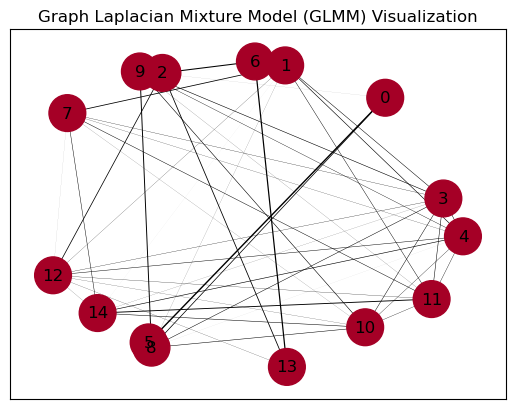

In [20]:

n = 15  
m = 150  
k = 2
zero_thresh = 10e-4

g = [generate_connected_graph(n, 0.7, zero_thresh) for _ in range(k)]

gamma = np.random.rand(m, 1)
gamma_cut = np.zeros((m, k))
dist = 0.5
p = np.linspace(0, 1, k + 1)
y = np.zeros((m, n))
true_y = np.zeros((m, n, k))
center = np.zeros((n, k))
gauss = np.zeros((n, n, k))
Lap = np.zeros((n, n, k))

for i in range(k):
    gc = pinv(g[i])
    gauss[:, :, i] = (gc + gc.T) / 2
    Lap[:, :, i] = g[i]
    center[:, i] = dist * np.random.randn(n)
    center[:, i] = center[:, i] - np.mean(center[:, i])
    gamma_cut[(p[i] < gamma[:, 0]) & (gamma[:, 0] <= p[i + 1]), i] = 1
    true_y[:, :, i] = gamma_cut[:, i][:, np.newaxis] * np.random.multivariate_normal(center[:, i], gauss[:, :, i], m)
    y += true_y[:, :, i]

iterations = 200
Ls, gamma_hats, mus, log_likelihood = glmm(y, iterations, k)
print('Training done')

print(np.sum(gamma_hats, axis=0))

identify, precision, recall, f, cl_errors ,NMI_score , num_of_edges = identify_and_compare(Ls, Lap, gamma_hats, gamma_cut, k)

print("Identify:", identify)
print("Precision:", precision)
print("Recall:", recall)
print("F-measure:", f)
print("Cluster Errors:", cl_errors)
print('Normalized mutual information', NMI_score)
print("Number of estimated edges", num_of_edges)
summed_gamma_hats = np.sum(gamma_hats, axis=1)
summed_gamma_hats_column = summed_gamma_hats[:, np.newaxis]
are_all_elements_one = np.allclose(summed_gamma_hats_column, 1, atol=1e-8)
print("\nAre all elements in the colum wise summed gamma_hat equal to 1:", are_all_elements_one)
visualize_glmm(Ls, gamma_hats)